In [1]:
#Importando do Google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Instalar pacote
!pip install category_encoders catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [68]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import sklearn.metrics as m
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
specificity = make_scorer(recall_score, pos_label=0)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score,classification_report,accuracy_score,precision_score,f1_score
import pickle

In [8]:
#Lendo dataframe
df = pd.read_csv('/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/Banco_Internacao.csv', sep=';').drop('Sexo', axis=1)

In [9]:
#Visualizando dataframe
df.head()

,DiasDePermanencia,NumeroInternacoes,ValorTotal,AnoInternacao,CaraterInternacao,Complexidade,DiagnosticoPrincipal,Especialidade,FoiAObito,Gestao,HospitalNome,Idade,MunicipioResidencia,ProcedimentoGrupo,RacaCor,Regime,TeveDiariasUTI
0,3,1,"467,66",2011,Eletiva,Media complexidade,Endocervix,Clinica Cirurgica,Nao,Municipal plena assist.,ASSOCIACAO MATOGROSSENSE DE COMBATE AO CANCER ...,46,CUIABA,PROCEDIMENTOS CIRURGICOS,*Nao informado,Privado,Nao
1,1,1,"45,93",2011,Eletiva,Media complexidade,Lesao invasiva,Clinica medica,Sim,Municipal plena assist.,HOSPITAL E PRONTO SOCORRO MUNICIPAL DE CUIABA,45,CUIABA,PROCEDIMENTOS CLINICOS,*Nao informado,Publico,Nao
2,5,1,"658,03",2011,Eletiva,Media complexidade,Nao especificado,Clinica Cirurgica,Nao,Municipal plena assist.,ASSOCIACAO MATOGROSSENSE DE COMBATE AO CANCER ...,45,PONTES E LACERDA,PROCEDIMENTOS CIRURGICOS,*Nao informado,Privado,Nao
3,2,1,"1216,84",2011,Urg/Emerg (Hosp Referꮣia),Alta complexidade,Ectocervix,Clinica Cirurgica,Nao,Municipal plena assist.,SOCIEDADE BENEFICENTE SANTA CASA DE MISERICORD...,40,VARZEA GRANDE,PROCEDIMENTOS CIRURGICOS,Parda,Privado,Nao
4,14,1,1100,2011,Urg/Emerg (Hosp Referꮣia),Alta complexidade,Nao especificado,Clinica medica,Nao,Municipal plena assist.,ASSOCIACAO MATOGROSSENSE DE COMBATE AO CANCER ...,34,SANTA HELENA,PROCEDIMENTOS CLINICOS,*Nao informado,Privado,Nao


In [11]:
df.shape

(3976, 17)

In [12]:
df.columns

Index(['DiasDePermanencia', 'NumeroInternacoes', 'ValorTotal', 'AnoInternacao',
       'CaraterInternacao', 'Complexidade', 'DiagnosticoPrincipal',
       'Especialidade', 'FoiAObito', 'Gestao', 'HospitalNome', 'Idade',
       'MunicipioResidencia', 'ProcedimentoGrupo', 'RacaCor', 'Regime',
       'TeveDiariasUTI'],
      dtype='object')

In [13]:
cols_num = ['DiasDePermanencia', 'NumeroInternacoes', 'ValorTotal','Idade']
cols_cat = ['AnoInternacao',
       'CaraterInternacao', 'Complexidade', 'DiagnosticoPrincipal',
       'Especialidade', 'FoiAObito', 'Gestao', 'HospitalNome',
       'MunicipioResidencia', 'ProcedimentoGrupo', 'RacaCor', 'Regime',
       'TeveDiariasUTI']

In [14]:
data = df.loc[:,cols_num + cols_cat]

In [15]:
data['ValorTotal']=data['ValorTotal'].str.replace(',','.')

In [16]:
data['ValorTotal']=data['ValorTotal'].astype(float)

In [17]:
data.columns

Index(['DiasDePermanencia', 'NumeroInternacoes', 'ValorTotal', 'Idade',
       'AnoInternacao', 'CaraterInternacao', 'Complexidade',
       'DiagnosticoPrincipal', 'Especialidade', 'FoiAObito', 'Gestao',
       'HospitalNome', 'MunicipioResidencia', 'ProcedimentoGrupo', 'RacaCor',
       'Regime', 'TeveDiariasUTI'],
      dtype='object')

In [18]:
data.FoiAObito.value_counts()

,count
FoiAObito,
Nao,3584
Sim,392


In [19]:
# Listas de colunas para cada tipo de encoding
label_encoding_cols = ['AnoInternacao', 'CaraterInternacao', 'Complexidade', 'DiagnosticoPrincipal', 'Especialidade',
                       'Gestao','ProcedimentoGrupo','RacaCor','Regime','TeveDiariasUTI','FoiAObito']
target_encoding_cols = ['HospitalNome', 'MunicipioResidencia','DiagnosticoPrincipal']

# Aplicando Label Encoding nas colunas especificadas
label_encoder = LabelEncoder()
for col in label_encoding_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Aplicando Target Encoding nas colunas especificadas
target_encoder = TargetEncoder(cols=target_encoding_cols)
data[target_encoding_cols] = target_encoder.fit_transform(data[target_encoding_cols], data['FoiAObito'])

# Visualizando as primeiras linhas para verificar os resultados
data.head()

,DiasDePermanencia,NumeroInternacoes,ValorTotal,Idade,AnoInternacao,CaraterInternacao,Complexidade,DiagnosticoPrincipal,Especialidade,FoiAObito,Gestao,HospitalNome,MunicipioResidencia,ProcedimentoGrupo,RacaCor,Regime,TeveDiariasUTI
0,3,1,467.66,46,0,0,1,0.024976,0,0,1,0.149837,0.113150,0,0,0,0
1,1,1,45.93,45,0,0,1,0.145374,1,1,1,0.219330,0.113150,1,0,1,0
2,5,1,658.03,45,0,0,1,0.139294,0,0,1,0.149837,0.038081,0,0,0,0
3,2,1,1216.84,40,0,1,0,0.010811,0,0,1,0.160494,0.137845,0,4,0,0
4,14,1,1100.00,34,0,1,0,0.139294,1,0,1,0.149837,0.155532,1,0,0,0


In [20]:
# Separando a variável alvo e as features
X = data.drop(columns=['FoiAObito'])
y = data['FoiAObito']

In [88]:
# Dicionário de mapeamento para inglês
mapping = {
    "DiasDePermanencia": "Length of Stay",
    "NumeroInternacoes": "Number of Admissions",
    "ValorTotal": "Total Cost",
    "Idade": "Age",
    "AnoInternacao": "Year of Admission",
    "CaraterInternacao": "Admission Type",
    "Complexidade": "Complexity",
    "DiagnosticoPrincipal": "Main Diagnosis",
    "Especialidade": "Medical Specialty",
    "FoiAObito": "Death",
    "Gestao": "Management",
    "HospitalNome": "Hospital",
    "MunicipioResidencia": "City of Residence",
    "ProcedimentoGrupo": "Procedure Group",
    "RacaCor": "Race Color",
    "Regime": "Regimen",
    "TeveDiariasUTI": "Intensive Unit Care"
}

# Renomeia as colunas do DataFrame X_test
X = X.rename(columns=mapping)

In [89]:
X.columns=['Length of Stay', 'Number of Admissions', 'Total Cost', 'Age',
       'Year of Admission', 'Admission Type', 'Complexity', 'Main Diagnosis',
       'Medical Specialty', 'Management', 'Hospital', 'City of Residence',
       'Procedure Group', 'Race Color', 'Regimen', 'Intensive Care Unit']

In [92]:
# Separar as colunas categóricas e numéricas
numeric_cols = ['Length of Stay', 'Number of Admissions', 'Total Cost', 'Age']
categorical_cols = [
    'Year of Admission', 'Admission Type', 'Complexity', 'Main Diagnosis',
    'Medical Specialty', 'Management', 'Hospital', 'City of Residence',
    'Procedure Group', 'Race Color', 'Regimen', 'Intensive Care Unit'
]

# Tabela descritiva das variáveis numéricas
numeric_summary = X[numeric_cols].describe()

# Tabela descritiva das variáveis categóricas (frequências)
categorical_summary = X[categorical_cols].apply(lambda x: x.value_counts())

# Matriz de Correlação das Variáveis Numéricas
correlation_matrix_num = X[numeric_cols].corr()

# Matriz de Correlação das Variáveis Categóricas
correlation_matrix_cat = X[categorical_cols].corr()

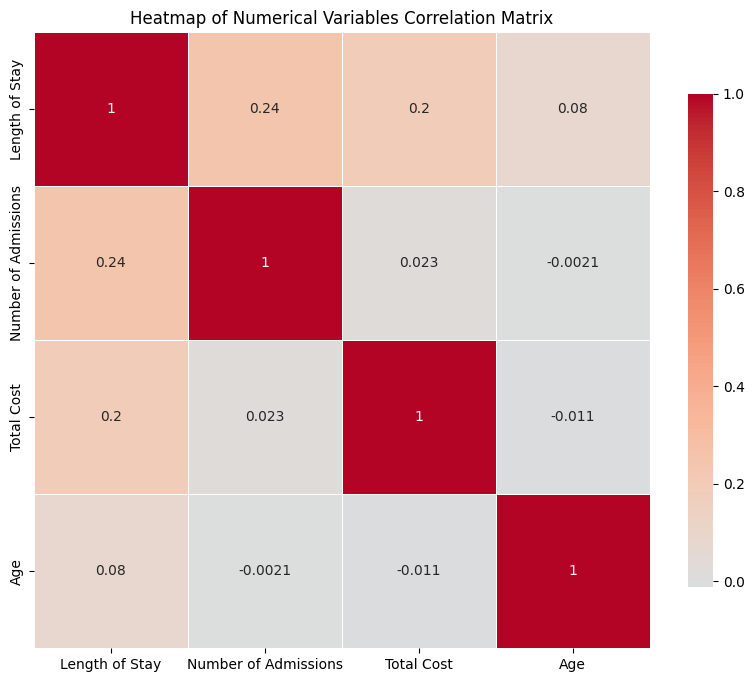

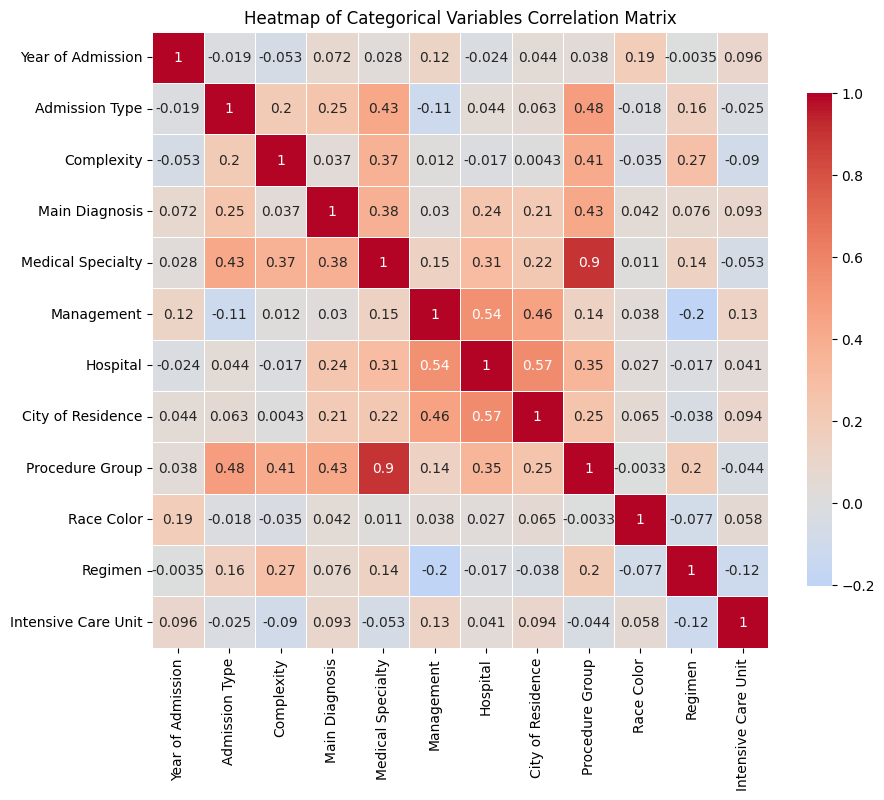

In [93]:
# Plotando o heatmap da matriz de correlação numérica
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_num, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Heatmap of Numerical Variables Correlation Matrix")
plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/heatmap_num_300dpi.png", dpi=300)
plt.show()

# Plotando o heatmap da matriz de correlação categórica
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_cat, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Heatmap of Categorical Variables Correlation Matrix")
plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/heatmap_cat_300dpi.png", dpi=300)
plt.show()

In [94]:
# Dividindo em treino e teste, mantendo a proporção da classe 'FoiAObito'
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verificando as proporções
print("Proporção de classes no treino:")
print(y_train.value_counts(normalize=True))
print("\nProporção de classes no teste:")
print(y_test.value_counts(normalize=True))

Proporção de classes no treino:
FoiAObito
0    0.901258
1    0.098742
Name: proportion, dtype: float64

Proporção de classes no teste:
FoiAObito
0    0.90201
1    0.09799
Name: proportion, dtype: float64


In [95]:
# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicando SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [96]:
# Definindo os modelos e os hiperparâmetros para Grid Search
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, silent=True), {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'iterations': [100, 200]
    }),
    'LGBM': (LGBMClassifier(random_state=42), {
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    })
}

In [97]:
# Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar os melhores modelos
best_models = {}

# Loop para rodar GridSearchCV para cada modelo e encontrar os melhores hiperparâmetros
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_smote, y_train_smote)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Melhores hiperparâmetros para LogisticRegression: {'C': 10}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores hiperparâmetros para RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores hiperparâmetros para CatBoost: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2866, number of negative: 2866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 5732, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


In [98]:
# Avaliação dos modelos no conjunto de teste
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\nRelatório de classificação para {model_name} no conjunto de teste:")
    print(classification_report(y_test, y_pred))


Relatório de classificação para LogisticRegression no conjunto de teste:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       718
           1       0.29      0.82      0.43        78

    accuracy                           0.78       796
   macro avg       0.63      0.80      0.65       796
weighted avg       0.91      0.78      0.82       796


Relatório de classificação para RandomForest no conjunto de teste:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       718
           1       0.32      0.31      0.32        78

    accuracy                           0.87       796
   macro avg       0.62      0.62      0.62       796
weighted avg       0.87      0.87      0.87       796


Relatório de classificação para CatBoost no conjunto de teste:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       718
           1       0.35      0.

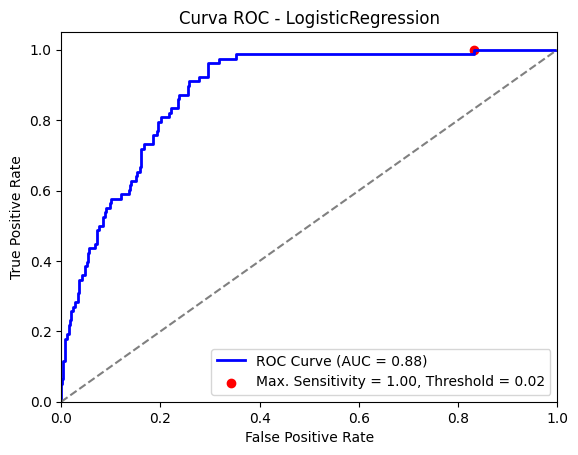


Relatório de classificação para LogisticRegression com threshold de máxima sensibilidade no teste:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29       718
           1       0.12      1.00      0.21        78

    accuracy                           0.25       796
   macro avg       0.56      0.58      0.25       796
weighted avg       0.91      0.25      0.28       796



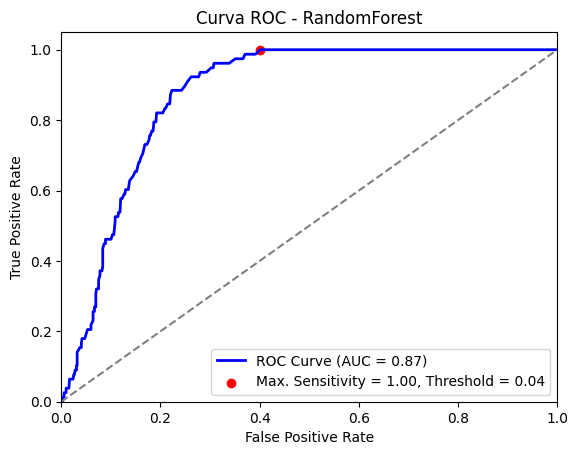


Relatório de classificação para RandomForest com threshold de máxima sensibilidade no teste:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       718
           1       0.21      1.00      0.35        78

    accuracy                           0.64       796
   macro avg       0.61      0.80      0.55       796
weighted avg       0.92      0.64      0.71       796



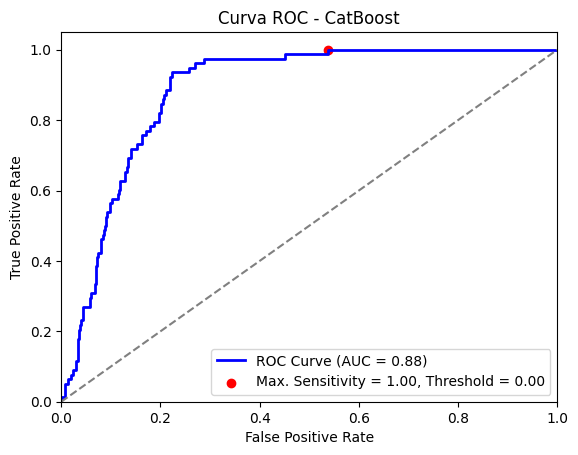


Relatório de classificação para CatBoost com threshold de máxima sensibilidade no teste:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       718
           1       0.17      1.00      0.29        78

    accuracy                           0.52       796
   macro avg       0.58      0.73      0.46       796
weighted avg       0.92      0.52      0.60       796



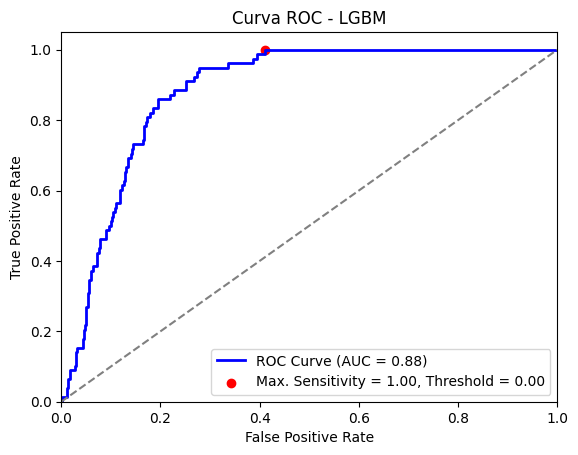


Relatório de classificação para LGBM com threshold de máxima sensibilidade no teste:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       718
           1       0.21      1.00      0.35        78

    accuracy                           0.63       796
   macro avg       0.60      0.79      0.54       796
weighted avg       0.92      0.63      0.70       796



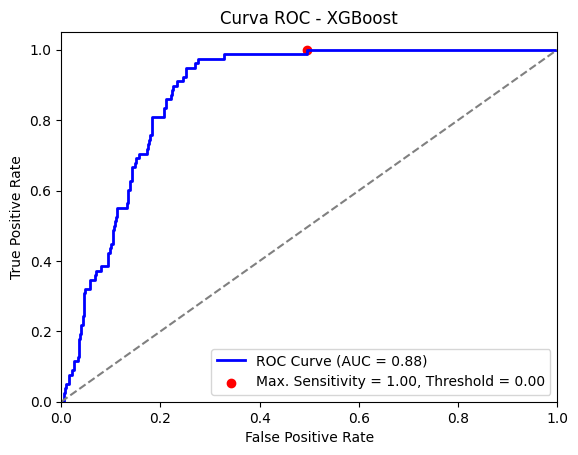


Relatório de classificação para XGBoost com threshold de máxima sensibilidade no teste:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       718
           1       0.18      1.00      0.30        78

    accuracy                           0.55       796
   macro avg       0.59      0.75      0.49       796
weighted avg       0.92      0.55      0.63       796



In [99]:
# Avaliação dos modelos no conjunto de teste
for model_name, model in best_models.items():
    # Obtenção das probabilidades de predição
    y_proba = model.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Encontrar o threshold que maximiza a sensibilidade
    max_sensitivity_idx = np.argmax(tpr)
    best_threshold = thresholds[max_sensitivity_idx]
    best_sensitivity = tpr[max_sensitivity_idx]

    # Plot da curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[max_sensitivity_idx], best_sensitivity, color='red',
                label=f'Max. Sensitivity = {best_sensitivity:.2f}, Threshold = {best_threshold:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f"/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/roc_auc_{model_name}_300dpi.png", dpi=300)
    plt.show()

    # Aplicando o melhor threshold para previsões binárias
    y_pred_best_threshold = (y_proba >= best_threshold).astype(int)

    # Relatório de classificação usando o threshold ótimo
    print(f"\nRelatório de classificação para {model_name} com threshold de máxima sensibilidade no teste:")
    print(classification_report(y_test, y_pred_best_threshold))


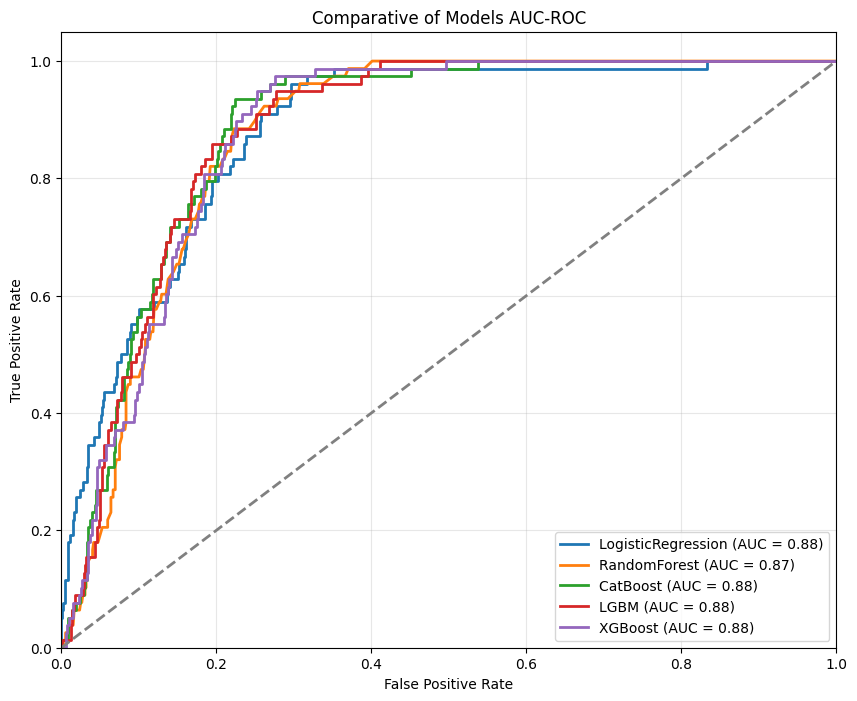

In [100]:
# Avaliação dos modelos no conjunto de teste
plt.figure(figsize=(10, 8))

# Certifique-se de que o dicionário esteja definido como 'best_models' ou altere o nome conforme necessário
for model_name, model in best_models.items():
    # Obtenção das probabilidades de predição
    y_proba = model.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot da curva ROC para cada modelo
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative of Models AUC-ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(f"/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/roc_auc_models_300dpi.png", dpi=300)
plt.show()

Modelo com melhor AUC no teste: CatBoost


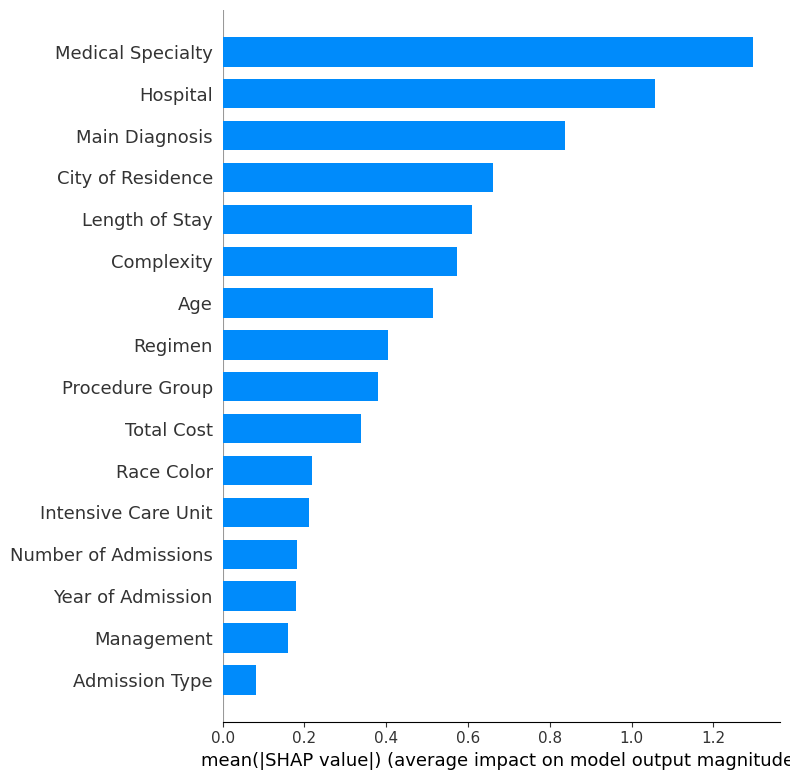

<Figure size 640x480 with 0 Axes>

In [101]:
import shap
import numpy as np
from sklearn.metrics import roc_auc_score

# Identificar o melhor modelo com base na métrica AUC no conjunto de teste
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test)[:, 1]))
best_model = best_models[best_model_name]
print(f"Modelo com melhor AUC no teste: {best_model_name}")

# Criar o interpretador SHAP com amostras de teste
explainer = shap.TreeExplainer(best_model) if best_model_name in ['Random Forest', 'CatBoost', 'LGBM', 'XGBoost'] else shap.KernelExplainer(best_model.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)

# Visualização dos valores SHAP para a classe positiva
if isinstance(shap_values, list):  # Caso de múltiplas classes (e.g., árvore de decisão)
    shap_values_class = shap_values[1]  # Classe positiva
else:
    shap_values_class = shap_values

# Gráfico de Importância das Variáveis
shap.summary_plot(shap_values_class, X_test, plot_type="bar")

# Salva o gráfico com 300 DPI
plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/shap_bar_300dpi_en.png", dpi=300, bbox_inches='tight')
plt.show()  # Mostra o gráfico apenas se necessário

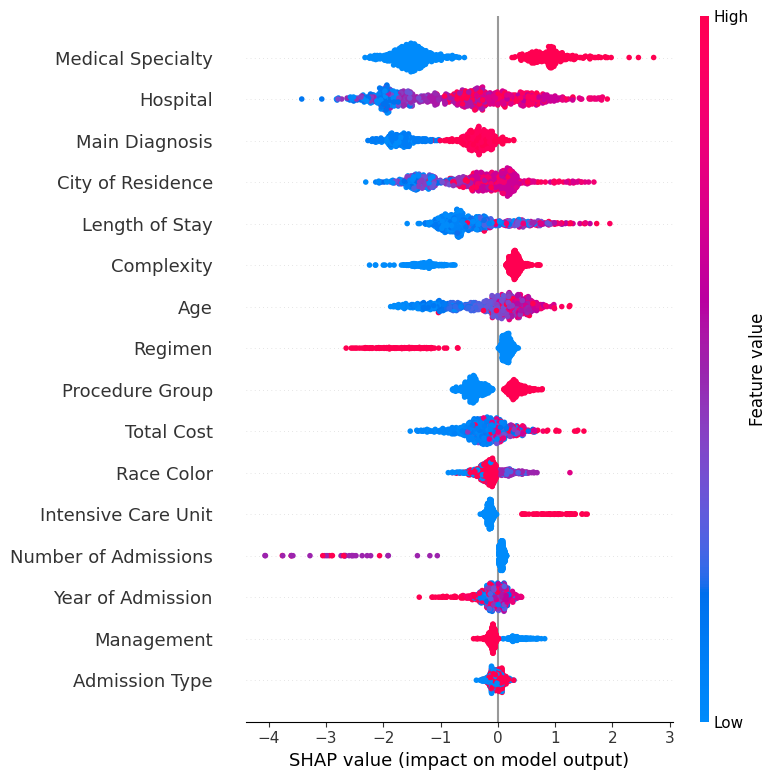

<Figure size 640x480 with 0 Axes>

In [102]:
# Gráfico de Beeswarm para uma visão detalhada
shap.summary_plot(shap_values_class, X_test)

# Salva o gráfico com 300 DPI
plt.savefig("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/shap_bsw_300dpi_en.png", dpi=300, bbox_inches='tight')
plt.show()  # Mostra o gráfico apenas se necessário

In [103]:
# Tabela para armazenar os resultados
summary_results = []

# Loop pelos melhores modelos para calcular as métricas
for model_name, model in best_models.items():
    # Previsões de probabilidade para a classe positiva
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular a curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Encontrar o threshold que maximiza a sensibilidade
    max_sensitivity_idx = np.argmax(tpr)
    best_threshold = thresholds[max_sensitivity_idx]

    # Calcular as previsões binárias usando o threshold otimizado
    y_pred_best_threshold = (y_proba >= best_threshold).astype(int)

    # Calcular métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred_best_threshold)
    recall = recall_score(y_test, y_pred_best_threshold)
    precision = precision_score(y_test, y_pred_best_threshold)
    f1 = f1_score(y_test, y_pred_best_threshold)
    mcc = matthews_corrcoef(y_test, y_pred_best_threshold)

    # Calcular matriz de confusão para especificidade
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best_threshold).ravel()
    specificity = tn / (tn + fp)

    # Adiciona os resultados na tabela de sumarização
    summary_results.append({
        'Modelo': model_name,
        'AUC-ROC': f"{roc_auc:.2f}",
        'Accuracy': f"{accuracy:.2f}",
        'Recall': f"{recall:.2f}",
        'Specificity': f"{specificity:.2f}",
        'Precision': f"{precision:.2f}",
        'F1': f"{f1:.2f}",
        'MCC': f"{mcc:.2f}"
    })

summary_df = pd.DataFrame(summary_results)

In [104]:
summary_df.to_csv("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/summary_df.csv")

In [105]:
# Tabela para armazenar os resultados
summary_results = []

# Loop pelos melhores modelos para calcular as métricas no threshold de 0.5
for model_name, model in best_models.items():
    # Previsões de probabilidade para a classe positiva
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular a curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Calcular previsões binárias usando o threshold fixo de 0.5
    y_pred_0_5 = (y_proba >= 0.5).astype(int)

    # Calcular métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred_0_5)
    recall = recall_score(y_test, y_pred_0_5)  # Sensibilidade
    precision = precision_score(y_test, y_pred_0_5)
    f1 = f1_score(y_test, y_pred_0_5)
    mcc = matthews_corrcoef(y_test, y_pred_0_5)

    # Calcular matriz de confusão para especificidade
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_0_5).ravel()
    specificity = tn / (tn + fp)

    # Adiciona os resultados na tabela de sumarização
    summary_results.append({
        'Modelo': model_name,
        'AUC-ROC': f"{roc_auc:.2f}",
        'Accuracy': f"{accuracy:.2f}",
        'Recall (Sensibilidade)': f"{recall:.2f}",
        'Specificity': f"{specificity:.2f}",
        'Precision': f"{precision:.2f}",
        'F1': f"{f1:.2f}",
        'Threshold': "0.5",
        'MCC': f"{mcc:.2f}"
    })

# Convertendo para DataFrame e exibindo a tabela
summary_df_th05 = pd.DataFrame(summary_results)

In [106]:
summary_df_th05.to_csv("/content/drive/MyDrive/trabalhos/Prediçao Mort Cancer Mato Groso/summary_th_50.csv")